#### Assignment: Document Classification
##### Data 620, 
###### Team 1: Jason Givens-Doyle, Mehdi Khan, Paul Britton

Video link: https://youtu.be/Z_9_WaXEx34


##### The assignment:
It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  http://archive.ics.uci.edu/ml/datasets/Spambase

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

##### Solution:
The Data: The project used data downloaded from  Dataturks (https://dataturks.com/) that were collected to  explore cyber-bullying through email, messaging etc. The dataset has 20001 texts or messages, each of which were tagged by '1' or '0' indicating offensive or normal messages respectively. The downloaded document was a text file with each line representing a text/message in json (python dictionary) format.

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import requests
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,  TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics



Since each line was in json format, json.loads were used to get the data in python environment. Then a dataframe was created from the data with two columns containing the messages and the tags (Label):

In [2]:
with open('Cyber-Trolls.txt', 'r')as f:
        dataset = [line.strip() for line in f]
   
d = [json.loads(dictobject) for dictobject in dataset]
df = pd.DataFrame(d)
df.drop(["extras","metadata"], axis=1, inplace=True)
lbl= [d.get('label')[0] for d in df[df.columns[0]]]
df['Label']=lbl
df.drop(["annotation"], inplace=True,axis=1)
df.head()

,content,Label
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook R...,1
2,why did you fuck it up. I could do it all day ...,1
3,Dude they dont finish enclosing the fucking sh...,1
4,WTF are you talking about Men? No men thats no...,1


#### Data Exploration

In [3]:
df.groupby('Label').describe()

content                    
        count unique     top freq
Label                            
0       12179  11853    nope   21
1        7822   2789  #NAME?   18

The above table shows that there are 12,179 messages that were not considered offensive while 7,822 messages were offensive. The most frequent words in both categories do not seem to carry any special meaning toward those two categories. One interesting finding is that there are lesser number of unique words in the offensive messages indicating that same words were used to offend people. 

In [4]:
table = pd.DataFrame([['Avg. length of normal text:',
                       round(df.loc[df.Label=='0','content'].apply(len).mean(),2)],
                      ['Avg. length of offensive text:',
                       round(df.loc[df.Label=='1','content'].apply(len).mean(),2)]])
table.columns=['']*len(table.columns)
table

,,
0,Avg. length of normal text:,64.96
1,Avg. length of offensive text:,70.78


From the above table suggests average length of offensive messages is a bit higher than that of normal messages, so message length may not be an indicator of offensive or non offensive texts.

#### Text Pre- processing 
All the messages were tokenized i.e. each of the messages were split into individual words i.e. each of the texts were represented as a set of words. The punctuation were also removed from each of texts. Regular expression and tokenize from nltk library were used on the content column of the dataframe to achieve both.

In [5]:
tokenizer = RegexpTokenizer(r'\w+')
df['content']=df.content.apply(tokenizer.tokenize)
df.head()

,content,Label
0,"[Get, fucking, real, dude]",1
1,"[She, is, as, dirty, as, they, come, and, that...",1
2,"[why, did, you, fuck, it, up, I, could, do, it...",1
3,"[Dude, they, dont, finish, enclosing, the, fuc...",1
4,"[WTF, are, you, talking, about, Men, No, men, ...",1


The common words such as 'the', 'a', 'are' etc. that are not useful but occur frequently were also removed using stopwards from nltk package 

In [6]:
def remove_stopwords(txt):
    removed = [word for word in txt if word.lower() not in stopwords.words('english')] 
    return removed

df['content']=df.content.apply(remove_stopwords)
df.head()

,content,Label
0,"[Get, fucking, real, dude]",1
1,"[dirty, come, crook, Rengel, Dems, fucking, co...",1
2,"[fuck, could, day, Let, hour, Ping, later, sch...",1
3,"[Dude, dont, finish, enclosing, fucking, showe...",1
4,"[WTF, talking, Men, men, thats, menage, gay]",1


#### Vectorization
Vectorization is a process that converts text into numbers. So far each of the texts (messages) were converted into a list of tokens (words). The vectorization is needed to represent these texts in ML algorithms. There are multiple ways to do vectorization and some combination of which will be used here:

1. Term Document Matrix or term frequency: Counting the number of times each word appears in a document
2. TF-IDF (Term Frequency-Inverse Document Frequency): Weighting the frequency to asses relative importance of a term in the document and the entire corpus

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at words, characters, or n-grams levels. Only word level will be applied here.


Before vectorization was done, two sets of data were created to train and test classification models, the rows were selected randomly so that both datasets have reasonable numbers of offensive and non offensive messages:

In [7]:
df['content'] = [" ".join(con) for con in df['content'].values]
df_train = df.sample(frac=.8, random_state=100).reset_index(drop=True)
df_test = df.drop(df_train.index).sample(frac=1).reset_index(drop=True)

In [8]:
df_train.head(8)

,content,Label
0,anyone said Arial gonna beat ass,1
1,Hahaha Well take care would hate lose homeland...,1
2,filipina foreigner,0
3,hope singing along hate think torturing poor l...,1
4,Duck tape fixes everything,0
5,says gubgivits teeth thingies stole blood ever...,1
6,sucks,1
7,N3qRO WUZZ YA NUMBER,0


In [9]:
df_test.head()

,content,Label
0,okay seen long time,0
1,OKay Hope everything goes okay,0
2,would found 100 movie theater,0
3,Wow really persistent,0
4,yuh stalkers,0


##### Train data prepration:

In [10]:
bag_of_words = CountVectorizer()
# ignore terms that appear in more than 50% of the documents
#bag_of_words.set_params(max_df=0.5)
bag_of_words_fit = bag_of_words.fit(df_train['content'])


In [11]:
tdm_train = bag_of_words_fit.transform(df_train['content'])
print(tdm_train[5])

  (0, 1792)	2
  (0, 4575)	1
  (0, 5873)	1
  (0, 8744)	1
  (0, 11513)	1
  (0, 12052)	1
  (0, 12634)	1
  (0, 12691)	1
  (0, 12848)	1
  (0, 13196)	1
  (0, 13364)	1


Term weighting:

In [12]:
tfidf_fit_train = TfidfTransformer().fit(tdm_train)
tfidf_train = tfidf_fit_train.transform(tdm_train)
tfidf_train.shape

(16001, 15182)

In [13]:
tfidf_train

<16001x15182 sparse matrix of type '<class 'numpy.float64'>'
	with 109406 stored elements in Compressed Sparse Row format>

##### Test data prepration:

In [14]:
#bag_of_words_test = CountVectorizer()
# ignore terms that appear in more than 50% of the documents
#bag_of_words_test.set_params(max_df=0.5)
#bag_of_words_test.fit(df_test['content'])

tdm_test =bag_of_words.transform(df_test['content'])
tdm_test.shape


(4000, 15182)

In [15]:
print(tdm_test[5])

  (0, 4804)	1
  (0, 5968)	1
  (0, 6725)	1


In [16]:
tfidf_fit_test = TfidfTransformer().fit(tdm_test)
tfidf_test = tfidf_fit_test.transform(tdm_test)
tfidf_test.shape


(4000, 15182)

In [17]:
tfidf_test

<4000x15182 sparse matrix of type '<class 'numpy.float64'>'
	with 18540 stored elements in Compressed Sparse Row format>

### Model Building:

Next we examine various different classifier models in the context of this data.

###### Naive Bayes Model:

In [18]:
from sklearn.naive_bayes import MultinomialNB
online_troll_model_NB = MultinomialNB().fit(tfidf_train,df_train['Label'])

Prediting Label for test dataset using the model:

In [19]:

predicted_label = online_troll_model_NB.predict(tfidf_test)


##### Accuracy test:

In [20]:
metrics.accuracy_score(df_test['Label'], predicted_label)

0.98775

The naive bayes model showed almost 99% accuracy, which is impressive

###### Random Forest Model:

Here we explore the train_test_split function in sklearn:

In [21]:
from sklearn.ensemble import RandomForestClassifier

tfidf =  bag_of_words.fit_transform(df['content'])

X_train,X_test,y_train,y_test = train_test_split(tfidf,df['Label'],test_size=0.3,random_state=42)

online_troll_model_RF = RandomForestClassifier().fit(X_train,y_train)
predicted= online_troll_model_RF.predict(X_test)
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, predicted))

Random Forest Accuracy: 0.8386935510748209


The random forest model substantially under-performs the naive bayes test

###### K-Nearest-Neighbors Model:

In [22]:
from sklearn.neighbors import KNeighborsClassifier

tfidf =  bag_of_words.fit_transform(df['content'])

online_troll_model_KNN = KNeighborsClassifier().fit(X_train,y_train)
predicted= online_troll_model_KNN.predict(X_test)
print("KNN Accuracy:",metrics.accuracy_score(y_test, predicted))

KNN Accuracy: 0.6978836860523246


The KNN model substantially underperforms both the Naive Bayes and Random Forest models

###### SVM  Model:

In [23]:
from sklearn.svm import SVC

online_troll_model_SVM = SVC().fit(X_train,y_train)
predicted= online_troll_model_SVM.predict(X_test)
print("SVM Accuracy:",metrics.accuracy_score(y_test, predicted))


SVM Accuracy: 0.6108981836360606


Once again, the SVM model substantially underperforms the first model attempted

###### AdaBoost  Model:

In [24]:
from sklearn.ensemble import AdaBoostClassifier

online_troll_model_ADA = AdaBoostClassifier().fit(X_train,y_train)
predicted= online_troll_model_ADA.predict(X_test)
print("AdaBoost Accuracy:",metrics.accuracy_score(y_test, predicted))


AdaBoost Accuracy: 0.6868855190801533


The adaboost model also underperforms the  Naive Bayes as well

###### GradientBoost  Model:

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

online_troll_model_GBC = GradientBoostingClassifier().fit(X_train,y_train)
predicted= online_troll_model_GBC.predict(X_test)
print("SVM Accuracy:",metrics.accuracy_score(y_test, predicted))

SVM Accuracy: 0.6922179636727213


Not surprisingly, the Gradient Boost model is yet another underperformer.  At this point, a baysian thinker would probably conclude that the naive bayes approach is an effective approach for this problem.


##### Ensemble:

Finally, we examine an ensemble of all the models tested above.  

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
import warnings 

warnings.filterwarnings('ignore')  #suppressing a few warnings... 

#create the models
NB = MultinomialNB()
RF = RandomForestClassifier()
KNN = KNeighborsClassifier()
SVM = SVC()
ADA = AdaBoostClassifier()
GBC = GradientBoostingClassifier()


clf = [NB,RF,KNN,SVM,ADA,GBC]

eclf = VotingClassifier(estimators=[('Naive Bayes', NB),
                                    ('Random Forests', RF),
                                    ('KNN', KNN),
                                    ('SVM', SVM),
                                    ('AdaBoost', ADA),
                                    ('GradientBoost', GBC)], voting='hard')

scoreDict = {}

for clf, label in zip([NB,RF,KNN,SVM,ADA,GBC,eclf], ['Naive Bayes', 'Random Forests','KNN','SVM','AdaBoost','GradientBoost', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    scoreDict[label] = scores.mean()
    print("Accuracy: %0.2f [%s]" % (scores.mean(), label))


Accuracy: 0.77 [Naive Bayes]
Accuracy: 0.83 [Random Forests]
Accuracy: 0.70 [KNN]
Accuracy: 0.61 [SVM]
Accuracy: 0.70 [AdaBoost]
Accuracy: 0.71 [GradientBoost]
Accuracy: 0.73 [Ensemble]


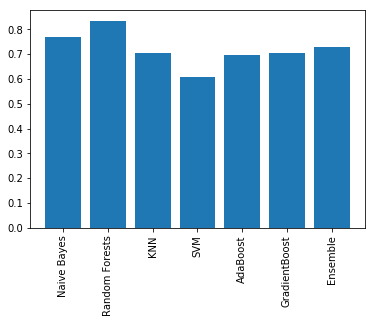

In [31]:
import matplotlib.pyplot as plt

plt.bar(range(len(scoreDict)), list(scoreDict.values()), align='center')
plt.xticks(range(len(scoreDict)), list(scoreDict.keys()),rotation='vertical')

plt.show()

We can see from the above that the ensemble doesn't add much value here.  In fact, we might want to drop a few of these models altogether in order to try to improve performance.  Next steps here would be to run a GridSearchCV in order to tune the collection of models found here.